In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from ucimlrepo import fetch_ucirepo

import keras
from keras.models import Model
from keras.layers import Dense, Input, Identity
from keras import optimizers
from kdm.models import KDMRegressModel
from kdm.utils import dm_rbf_expectation, dm_rbf_variance, dm_rbf_loglik


In [51]:
# Configuración inicial
os.environ["KERAS_BACKEND"] = "tensorflow"

# Cargar y preparar datos
combined_cycle_power_plant = fetch_ucirepo(id=294)
X = combined_cycle_power_plant.data.features
y = combined_cycle_power_plant.data.targets

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalamiento de características
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = MinMaxScaler((0.2, 0.8))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Instantiate a Gaussian Process model as baseline
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.01, n_restarts_optimizer=10)

In [52]:
def train_kdm_model(X_train, y_train, n_comp=20, generative=False, epochs=100):
    encoded_size = X_train.shape[1]
    dim_y = 1
    encoder = keras.Sequential([Identity()])
    
    kdm_model = KDMRegressModel(
        encoded_size=encoded_size,
        dim_y=dim_y,
        encoder=encoder,
        n_comp=n_comp,
        sigma_x=0.1,
        sigma_y=0.1,
        generative=generative
    )
    
    kdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3))
    
    # Inicializar componentes
    idx = np.random.randint(X_train.shape[0], size=n_comp)
    kdm_model.init_components(X_train[idx], y_train[idx], init_sigma=True)
    
    # Entrenamiento
    losses = []
    sigma_x = []
    sigma_y = []
    for i in range(epochs):
        history = kdm_model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
        losses.append(history.history['loss'][0])
        sigma_x.append(keras.ops.convert_to_numpy(kdm_model.kernel.sigma))
        sigma_y.append(keras.ops.convert_to_numpy(kdm_model.sigma_y))
    
    # Visualizar el entrenamiento
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(losses)
    plt.title("Loss")
    plt.subplot(132)
    plt.plot(sigma_x)
    plt.title("Sigma X")
    plt.subplot(133)
    plt.plot(sigma_y)
    plt.title("Sigma Y")
    plt.tight_layout()
    plt.show()
    
    return kdm_model

Entrenando modelo discriminativo...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


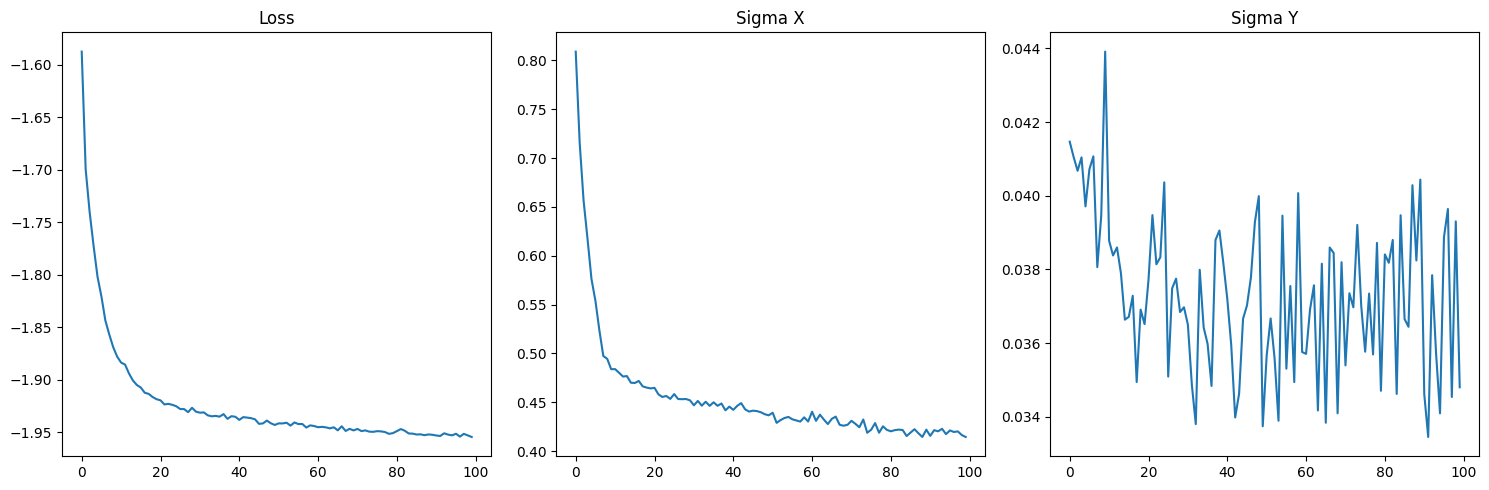

In [53]:
# Entrenar modelo discriminativo
print("Entrenando modelo discriminativo...")
kdm_disc_model = train_kdm_model(X_train_scaled, y_train_scaled, n_comp=30, generative=False)




Entrenando modelo generativo...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


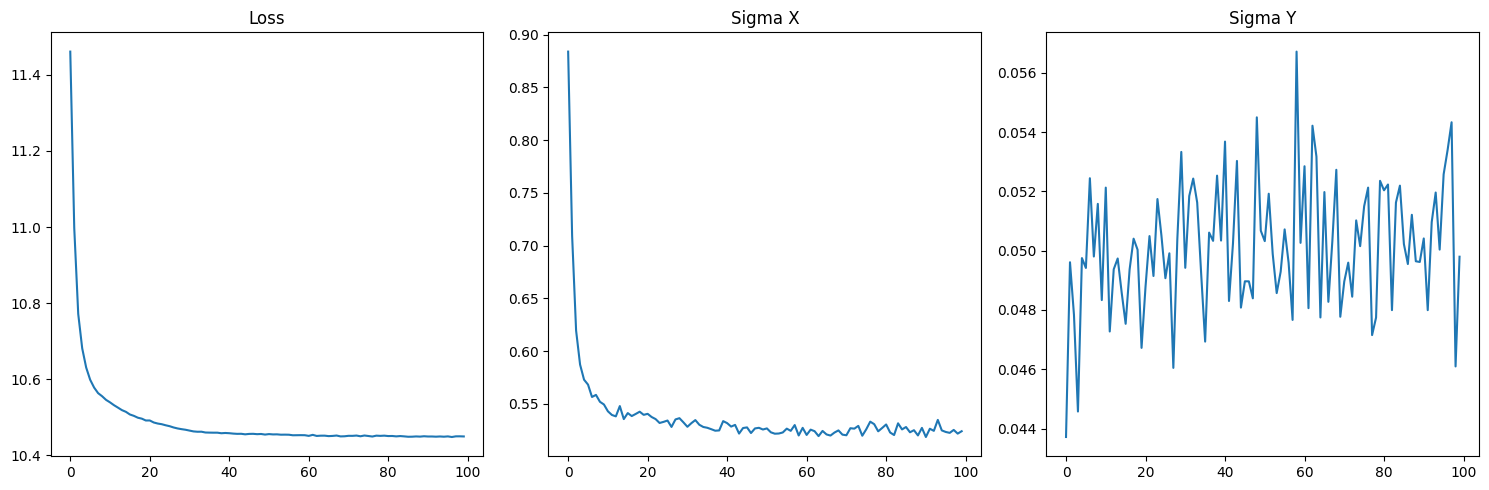

In [54]:
# Entrenar modelo generativo
print("\nEntrenando modelo generativo...")
kdm_gen_model = train_kdm_model(X_train_scaled, y_train_scaled, n_comp=30, generative=True)

In [55]:
def evaluate_model(model, X_test, y_test, model_name):
    rho_y = model.predict(X_test)
    y_pred = keras.ops.convert_to_numpy(dm_rbf_expectation(rho_y))
    y_var = keras.ops.convert_to_numpy(dm_rbf_variance(rho_y, model.sigma_y))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nResultados para {model_name}:")
    print(f"MSE: {mse}")
    print(f"X_sigma: {keras.ops.convert_to_numpy(model.kernel.sigma) / np.sqrt(2)}")
    print(f"Y_sigma: {keras.ops.convert_to_numpy(model.sigma_y) / np.sqrt(2)}")
    print(f"Varianza promedio: {np.mean(y_var)}")
    print(f"R2: {r2}")
    
    return y_pred, y_var

In [56]:
# Evaluar ambos modelos
y_pred_disc, y_var_disc = evaluate_model(kdm_disc_model, X_test_scaled, y_test_scaled, "Modelo Discriminativo")
y_pred_gen, y_var_gen = evaluate_model(kdm_gen_model, X_test_scaled, y_test_scaled, "Modelo Generativo")


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Resultados para Modelo Discriminativo:
MSE: 0.0012572575212921508
X_sigma: 0.2930195579510171
Y_sigma: 0.02461011119378789
Varianza promedio: 0.00161879719235003
R2: 0.9320934822122782
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Resultados para Modelo Generativo:
MSE: 0.0016026439254504842
X_sigma: 0.37049216686295355
Y_sigma: 0.03520999617907316
Varianza promedio: 0.0023224086035043
R2: 0.9134386023643453


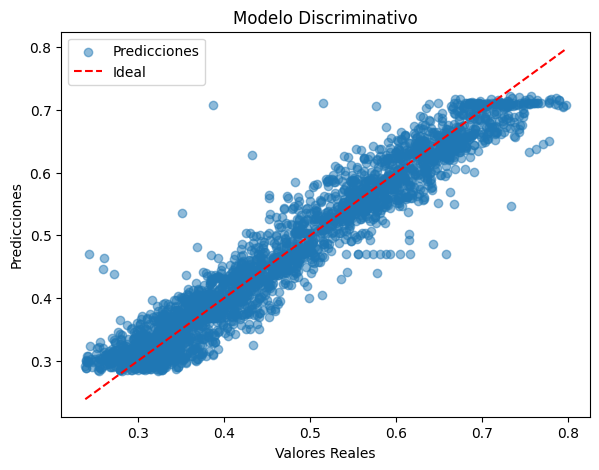

In [57]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.scatter(y_test_scaled, y_pred_disc, alpha=0.5, label='Predicciones')
plt.plot([y_test_scaled.min(), y_test_scaled.max()], 
         [y_test_scaled.min(), y_test_scaled.max()], 
         'r--', label='Ideal')
plt.title('Modelo Discriminativo')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()

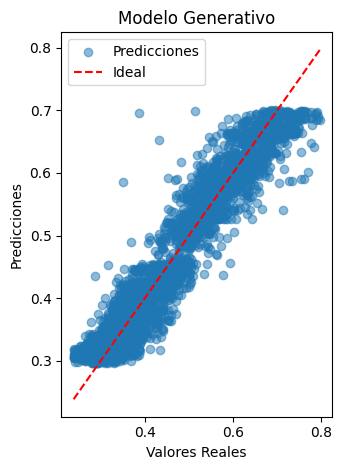

In [58]:
plt.subplot(122)
plt.scatter(y_test_scaled, y_pred_gen, alpha=0.5, label='Predicciones')
plt.plot([y_test_scaled.min(), y_test_scaled.max()], 
         [y_test_scaled.min(), y_test_scaled.max()], 
         'r--', label='Ideal')
plt.title('Modelo Generativo')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frecuencia')

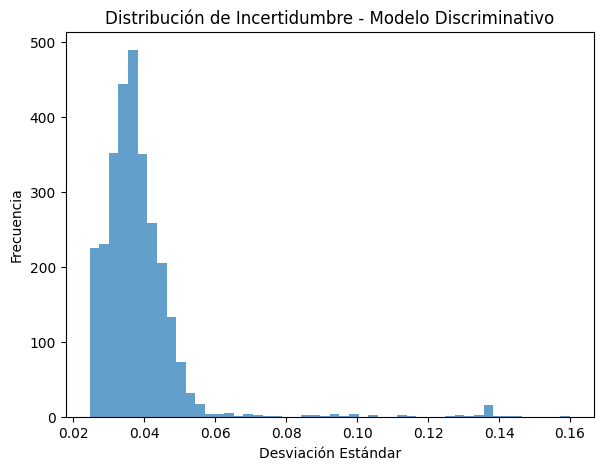

In [59]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(np.sqrt(y_var_disc), bins=50, alpha=0.7)
plt.title('Distribución de Incertidumbre - Modelo Discriminativo')
plt.xlabel('Desviación Estándar')
plt.ylabel('Frecuencia')

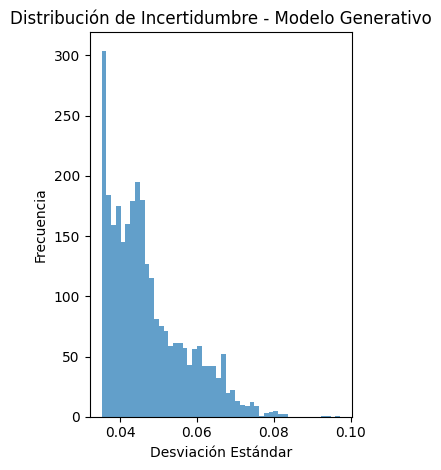

In [60]:
plt.subplot(122)
plt.hist(np.sqrt(y_var_gen), bins=50, alpha=0.7)
plt.title('Distribución de Incertidumbre - Modelo Generativo')
plt.xlabel('Desviación Estándar')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()